In [1]:
cd /tf/astromer

/tf/astromer


In [10]:
import matplotlib.pyplot as plt
import tensorflow as tf 
import pandas as pd
import json
import os 


from core.classifier import get_lstm_attention, get_lstm_no_attention, predict
from core.data  import clf_records
from sklearn.metrics import confusion_matrix
from core.plots import plot_cm

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
def get_conf(path):
    conf_file = os.path.join(lstm_no_att_path, 'conf.json')
    with open(conf_file, 'r') as handle:
        conf = json.load(handle)
        return conf

def load_weights(model, weigths):
    weights_path = '{}/weights'.format(weigths)
    model.load_weights(weights_path)
    return model

In [12]:
lstm_no_att_path = './runs/clf_ogle_non_att'
lstm_att_path = './runs/clf_ogle'

In [13]:
conf_non_att = get_conf(lstm_no_att_path)
conf_att = get_conf(lstm_att_path)

In [14]:
lstm_att = get_lstm_attention(conf_att['units'], conf_att['num_classes'], conf_att['w'], conf_att['dropout'])
lstm_non_att = get_lstm_no_attention(conf_non_att['units'], conf_non_att['num_classes'], conf_non_att['max_obs'], conf_non_att['dropout'])

In [15]:
lstm_att     = load_weights(lstm_att, lstm_att_path)
lstm_non_att = load_weights(lstm_non_att, lstm_no_att_path)

In [8]:
test_batches = clf_records(os.path.join(conf_att['data'], 'test'),
                            256,
                            max_obs=conf_att['max_obs'])

In [16]:
att_results, y_true_att, y_pred_att = predict(lstm_att, test_batches)
non_att_results, y_true, y_pred = predict(lstm_non_att, test_batches)

test: 0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['lcid', 'label'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
test: 350it [02:06,  2.76it/s]
test: 0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['lcid', 'label'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
test: 350it [01:25,  4.08it/s]


In [17]:
cm_att = confusion_matrix(y_true_att, y_pred_att, normalize='true')
cm     = confusion_matrix(y_true, y_pred, normalize='true')

In [30]:
print('F1   - PREC - RECA - ACC')
print('{:.2f} - {:.2f} - {:.2f} - {:.2f}'.format(non_att_results['f1'], non_att_results['precision'],
                                                 non_att_results['recall'], non_att_results['accuracy']))

print('{:.2f} - {:.2f} - {:.2f} - {:.2f}'.format(att_results['f1'], att_results['precision'],
                                                 att_results['recall'], att_results['accuracy']))

F1   - PREC - RECA - ACC
0.60 - 0.69 - 0.56 - 0.82
0.50 - 0.62 - 0.46 - 0.80


In [35]:
cls_names = pd.read_csv(os.path.join(conf_att['data'], 'objects.csv'))['label'].values
cls_names

array(['EC', 'ED', 'ESD', 'Mira', 'OSARG', 'RRab', 'RRc', 'SRV', 'cep',
       'dsct', 'std'], dtype=object)

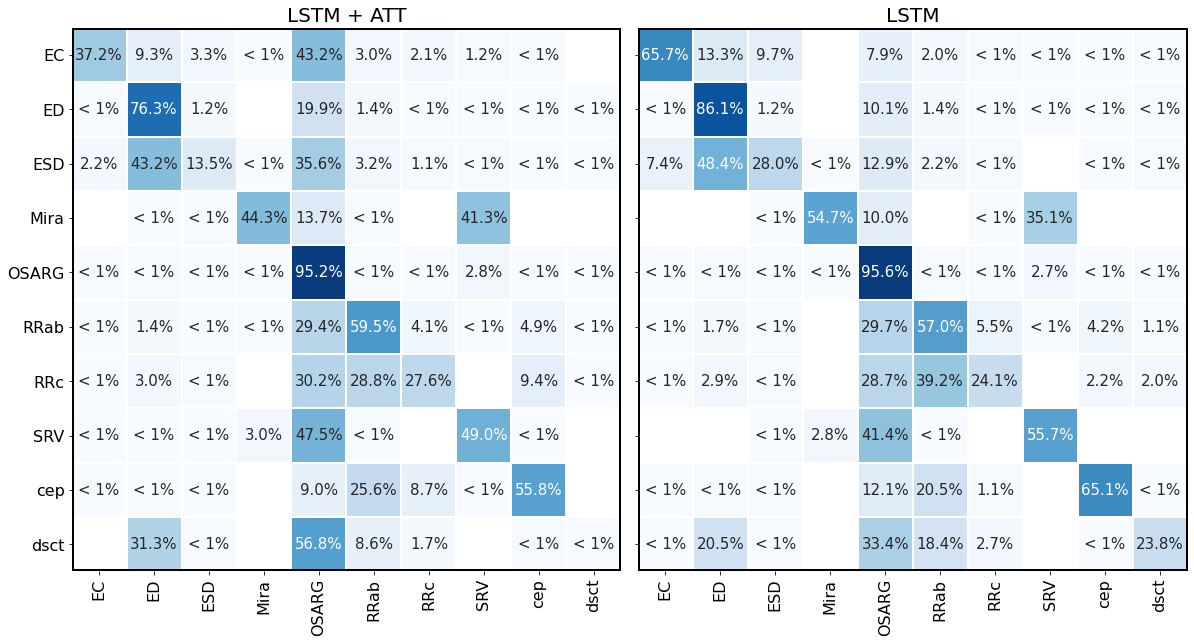

In [39]:
fig, axes = plt.subplots(1,2, figsize=(20,10), sharey=True, gridspec_kw={'hspace': 0., 'wspace': 0.03})

axes[0] = plot_cm(cm_att, axes[0], title='LSTM + ATT', class_names=cls_names[:-1])
axes[1] = plot_cm(cm, axes[1], title='LSTM', class_names=cls_names[:-1])